# HiPPO Matrices
---

## Load Packages

In [3]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from functools import partial
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from einops import rearrange, reduce, repeat

print(f"MPS enabled: {torch.backends.mps.is_available()}")

MPS enabled: False


In [5]:
## import packages
import math

import requests

from scipy import linalg as la
from scipy import signal
from scipy import special as ss

from src.data.process import moving_window, rolling_window
# import modules 
from src.models.hippo.gu_transition import GuTransMatrix
from src.models.hippo.unroll import (basis, measure, variable_unroll_matrix,
                                     variable_unroll_matrix_sequential)

device = torch.device("cpu")
print(f"The Device: {device}")

The Device: cpu


In [6]:
torch.set_printoptions(linewidth=150)
np.set_printoptions(linewidth=150)

In [7]:
seed = 1701

In [ ]:
def whitesignal(period, dt, freq, rms=0.5, batch_shape=()):
    """
    Produces output signal of length period / dt, band-limited to frequency freq
    Output shape (*batch_shape, period/dt)
    Adapted from the nengo library
    """

    if freq is not None and freq < 1. / period:
        raise ValueError(f"Make ``{freq=} >= 1. / {period=}`` to produce a non-zero signal",)

    nyquist_cutoff = 0.5 / dt
    if freq > nyquist_cutoff:
        raise ValueError(f"{freq} must not exceed the Nyquist frequency for the given dt ({nyquist_cutoff:0.3f})")

    n_coefficients = int(np.ceil(period / dt / 2.))
    shape = batch_shape + (n_coefficients + 1,)
    sigma = rms * np.sqrt(0.5)
    coefficients = 1j * np.random.normal(0., sigma, size=shape)
    coefficients[..., -1] = 0.
    coefficients += np.random.normal(0., sigma, size=shape)
    coefficients[..., 0] = 0.

    set_to_zero = np.fft.rfftfreq(2 * n_coefficients, d=dt) > freq
    coefficients *= (1-set_to_zero)
    power_correction = np.sqrt(1. - np.sum(set_to_zero, dtype=float) / n_coefficients)
    if power_correction > 0.: coefficients /= power_correction
    coefficients *= np.sqrt(2 * n_coefficients)
    signal = np.fft.irfft(coefficients, axis=-1)
    signal = signal - signal[..., :1]  # Start from 0
    return signal

def gen_sig(T, dt, N, freq):
    u = whitesignal(T, dt, freq=freq, batch_shape=(1,))
    return torch.tensor(u)

In [ ]:
def gen_batch(batch_size = 16, data_size = 784, input_size = 28):
    seed = 1701
    x = torch.randint(0, 255, (batch_size, data_size))
    x = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
    # Torch docs: torch.tensor.unfold(starting dim, window_size, step_size) 
    #x = x.unfold(1, input_size, 1) 
    return x

## Instantiate The HiPPO Matrix

In [8]:
class HIPPO_LEGS(nn.Module):
    """Hippo class utilizing legs polynomial"""

    def __init__(self, N, gbt_alpha=0.5, maxlength=1024):
        super(HIPPO_LEGS, self).__init__()
        self.N=N
        self.gbt_alpha=gbt_alpha
        self.maxlength=maxlength
        
    def compute_A(self, n, k):
        '''
        Computes the values for the HiPPO A matrix row by column 
        using the piecewise equation on p. 31 eq. 29:
                (2n+1)^{1/2} (2k+ 1)^{1/2} if n > k  
        A_{nk} = n+1                       if n = k,
                 0                         if n < k
        , where n represents the row and k the columns. 
        
        Input:
            n (int):
                nth row of a square matrix of size N
            k (int):
                kth column of a square matrix of size N
        
        Returns:
            Values (float):
            Individual values for the elements in the A matrix. 
        '''
        if n > k:
            val = np.sqrt(2 * n + 1, dtype=np.float32) * np.sqrt(2 * k + 1, dtype=np.float32)
        if n == k:
            val = n + 1 
        if n < k:
            val = 0
        return val

    def compute_B(self, n):
        '''
        Computes the values for the HiPPO B matrix row by column 
        using the piecewise equation on p. 31 eq. 29:
        B_{n} = (2n+1)^{1/2}
        
        Input:
            n (int):
                nth column of a square matrix of size N.
            
        Returns:
            Values (float):
            Individual values for the elements in the B matrix.
            The next hidden state (aka coefficients representing the function, f(t))
        '''
        val = np.sqrt(2 * n + 1, dtype=np.float32)
        return val

    def get_A_and_B(self, N):
        '''
        Creates the HiPPO A and B matrix given the size N along a single axis of 
        a square matrix.
        
        Input: 
            N (int):
            Size N of a square matrix along a single axis.
        
        Returns: 
            A (np.ndarray)
                shape: (N,N)
                the HiPPO A matrix.
            B (np.ndarray)
                shape: (N,):
                The HiPPO B matrix.
        '''
        A = np.zeros((self.N, self.N), dtype=np.float32)
        B = np.zeros((self.N, 1), dtype=np.float32)

        for n in range(A.shape[0]):
            B[n][0] = self.compute_B(n)
            for k in range(A.shape[1]):
                A[n, k] = self.compute_A(n, k)

        return A  * -1, B
    
    def generalized_bilinear_transform(self, A, B, t, gbt_alpha):
        '''
        Performs the generalised bilinaer transform from p. 21 eq.13:
        c(t + ∆t) − ∆tαAc(t + ∆t) = (I + ∆t(1 − α)A)c(t) + ∆tBf(t)
        c(t + ∆t) = (I − ∆tαA)^{−1} (I + ∆t(1 − α)A)c(t) + ∆t(I − ∆tαA)^{−1}Bf(t).
        on the HiPPO matrix A and B, transforming them. 
        Input:
            A (np.ndarray):
                shape: (N, N)
                the HiPPO A matrix
            B (np.ndarray):
                shape: (N,)
                the HiPPO B matrix
            Timestep t = 1/input length at t (int):
        
        Output:
            GBTA (np.array):
                shape: (N, N)
                Transformed HiPPO A matrix.
            
            GBTB (np.array):
                shape: (N,)
                Transformed HiPPO B matrix.
        '''
        I = np.eye(A.shape[0], dtype=np.float32)
        delta_t = 1 / t
        EQ13_p1 = I - (delta_t * gbt_alpha * A)
        EQ13_p2 = I + (delta_t * (1 - gbt_alpha) * A)
        EQA = np.linalg.lstsq(EQ13_p1, EQ13_p2, rcond=None)[0]
        EQB =  np.linalg.lstsq(EQ13_p1, (delta_t * B), rcond=None)[0]         
        return EQA, EQB
    
    def get_stacked_GBT(self):
        A, B = self.get_A_and_B(self.N)
        GBTA_stacked = np.empty((self.maxlength, self.N, self.N), dtype=np.float32)
        GBTB_stacked = np.empty((self.maxlength, self.N, 1), dtype=np.float32)
        
        for t in range(1, self.maxlength + 1):
            GBTA, GBTB = self.generalized_bilinear_transform(A, B, t, self.gbt_alpha)
            GBTA_stacked[t-1] = GBTA
            GBTB_stacked[t-1] = GBTB
            
        return GBTA_stacked, GBTB_stacked
    
    def discrete_hippo_operator(self, A, B, f, c_t =  None):
        '''
        Input:
            A (np.ndarray):
                shape: (N, N)
                the discretized A matrix
            B (np.ndarray):
                shape: (N, 1)
                the discretized B matrix
            c_t (np.ndarray):
                shape: (batch size, input length, N)
                the initial hidden state
            f (np.ndarray):
                shape: (batch size, sequence length, 1)
                the input sequence
        Returns:
            The next hidden state (aka coefficients representing the function, f(t))
        '''

        f = f.unsqueeze(-1)
        lst = []
        
        if c_t is None:
            c_t = np.zeros((f.shape[1], self.N), dtype=np.float32)

        for t, f_t in enumerate(f):
            
            #part_1 = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float())
            #part_2 = np.squeeze(B[t], -1) * f_t.numpy()
            #c_t = part_1 + part_2
            c_t = F.linear(torch.tensor(c_t).float(), torch.tensor(A[t]).float()) + np.squeeze(B[t], -1) * f_t.numpy()
            lst.append(c_t)

        return np.stack(lst, axis=0, dtype=np.float32)
    
    def reconstruct(self, c, B):
        vals = np.linspace(0.0, 1.0, self.maxlength)
        eval_mat = (B * np.float32(ss.eval_legendre(np.expand_dims(np.arange(self.N, dtype=np.float32), -1), 2 * vals - 1))).T
        a = eval_mat @ np.float32(np.expand_dims(c, -1))
        return a
    
    def forward():
        pass

In [ ]:
class HiPPO_LSI(nn.Module):
    """Vanilla HiPPO-LegS model (scale invariant instead of time invariant)"""

    def __init__(
        self,
        N,
        method="legs",
        max_length=1024,
        discretization=0.5,
        lambda_n=1.0,
        alpha=0.0,
        beta=1.0,
    ):
        """
        max_length: maximum sequence length
        """
        super().__init__()
        self.N = N
        matrices = GuTransMatrix(
            N=N, measure=method, lambda_n=lambda_n, alpha=alpha, beta=beta
        )
        A = np.asarray(matrices.A, dtype=np.float32)
        B = np.asarray(matrices.B, dtype=np.float32)
        B = B.squeeze(-1)

        A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
        B_stacked = np.empty((max_length, N), dtype=B.dtype)

        for t in range(1, max_length + 1):
            At = A / t
            Bt = B / t
            if discretization == 0.0:  # forward
                A_stacked[t - 1] = np.eye(N) + At
                B_stacked[t - 1] = Bt
            elif discretization == 1.0:  # backward
                A_stacked[t - 1] = la.solve_triangular(
                    np.eye(N) - At, np.eye(N), lower=True
                )
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, Bt, lower=True)
            elif discretization == 0.5:  # bilinear
                # A_stacked[t - 1] = la.solve_triangular(
                #     np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True
                # )
                # B_stacked[t - 1] = la.solve_triangular(
                #     np.eye(N) - At / 2, Bt, lower=True
                # )
                alpha = 0.5
                A_stacked[t - 1] = np.linalg.lstsq(
                    np.eye(N) - (At * alpha), np.eye(N) + (At * alpha), rcond=None
                )[
                    0
                ]  # TODO: Referencing this: https://stackoverflow.com/questions/64527098/numpy-linalg-linalgerror-singular-matrix-error-when-trying-to-solve
                B_stacked[t - 1] = np.linalg.lstsq(
                    np.eye(N) - (At * alpha), Bt, rcond=None
                )[0]
                
            else:  # ZOH
                A_stacked[t - 1] = la.expm(A * (math.log(t + 1) - math.log(t)))
                # A_stacked[t - 1] = la.expm(At)
                B_stacked[t - 1] = la.solve_triangular(
                    A, A_stacked[t - 1] @ B - B, lower=True
                )
                
                # A_stacked[t - 1] = la.expm(At)
                # B_stacked[t - 1] = la.inv(A) @ (la.expm(At) - np.eye(A.shape[0])) @ B
                
                
        # self.register_buffer('A_stacked', torch.Tensor(A_stacked)) # (max_length, N, N)
        # self.register_buffer('B_stacked', torch.Tensor(B_stacked)) # (max_length, N)
        
        self.A_stacked = torch.Tensor(A_stacked.copy())  # (max_length, N, N)
        self.B_stacked = torch.Tensor(B_stacked.copy())  # (max_length, N)

        vals = np.linspace(0.0, 1.0, max_length)
        
        self.eval_matrix = torch.from_numpy(
            np.asarray(
                ((B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T)
            )
        )

    def forward(self, inputs, fast=False):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """
        L = inputs.shape[0]    
        inputs = inputs.unsqueeze(-1)
        u = torch.transpose(inputs, 0, -2)
        u = u * self.B_stacked[:L]
        u = torch.transpose(u, 0, -2)  # (length, ..., N)
        if fast:
            result = variable_unroll_matrix(self.A_stacked[:L], u)
            return result

        c = torch.zeros(u.shape[1:]).to(inputs)
        cs = []
        for t, f in enumerate(inputs):
    
            part1 = F.linear(c, self.A_stacked[t])
            part2 = self.B_stacked[t] * f
            c = part1 + part2
            cs.append(c)
        return torch.stack(cs, dim=0)
    
    def reconstruct(self, c):
        a = self.eval_matrix.to(c) @ c.unsqueeze(-1)
        return a


In [ ]:
def transition(measure, N, **measure_args):
    # Laguerre (translated)
    if measure == 'lagt':
        b = measure_args.get('beta', 1.0)
        A = np.eye(N) / 2 - np.tril(np.ones((N, N)))
        B = b * np.ones((N, 1))
    # Legendre (translated)
    elif measure == 'legt':
        Q = np.arange(N, dtype=np.float64)
        R = (2*Q + 1) ** .5
        j, i = np.meshgrid(Q, Q)
        A = R[:, None] * np.where(i < j, (-1.)**(i-j), 1) * R[None, :]
        B = R[:, None]
        A = -A
    # Legendre (scaled)
    elif measure == 'legs':
        q = np.arange(N, dtype=np.float64)
        col, row = np.meshgrid(q, q)
        r = 2 * q + 1
        M = -(np.where(row >= col, r, 0) - np.diag(q))
        T = np.sqrt(np.diag(2 * q + 1))
        A = T @ M @ np.linalg.inv(T)
        B = np.diag(T)[:, None]
        B = B.copy() # Otherwise "UserWarning: given NumPY array is not writeable..." after torch.as_tensor(B)
    elif measure == 'fourier':
        freqs = np.arange(N//2)
        d = np.stack([np.zeros(N//2), freqs], axis=-1).reshape(-1)[1:]
        A = 2*np.pi*(-np.diag(d, 1) + np.diag(d, -1))
        B = np.zeros(N)
        B[0::2] = 2
        B[0] = 2**.5
        A = A - B[:, None] * B[None, :]
        # A = A - np.eye(N)
        B *= 2**.5
        B = B[:, None]

    return A, B

In [ ]:
class HiPPOScale(nn.Module):
    """ Vanilla HiPPO-LegS model (scale invariant instead of time invariant) """
    def __init__(self, N, method='legs', max_length=1024, discretization='bilinear'):
        """
        max_length: maximum sequence length
        """
        super().__init__()
        self.N = N
        A, B = transition(method, N)
        B = B.squeeze(-1)
        A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
        B_stacked = np.empty((max_length, N), dtype=B.dtype)
        for t in range(1, max_length + 1):
            At = A / t
            Bt = B / t
            if discretization == 'forward':
                A_stacked[t - 1] = np.eye(N) + At
                B_stacked[t - 1] = Bt
            elif discretization == 'backward':
                A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, np.eye(N), lower=True)
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, Bt, lower=True)
            elif discretization == 'bilinear':
                A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True)
                B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, Bt, lower=True)
            else: # ZOH
                A_stacked[t - 1] = la.expm(A * (math.log(t + 1) - math.log(t)))
                B_stacked[t - 1] = la.solve_triangular(A, A_stacked[t - 1] @ B - B, lower=True)
        self.register_buffer('A_stacked', torch.Tensor(A_stacked)) # (max_length, N, N)
        self.register_buffer('B_stacked', torch.Tensor(B_stacked)) # (max_length, N)

        vals = np.linspace(0.0, 1.0, max_length)
        self.eval_matrix = torch.Tensor((B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T  )

    def forward(self, inputs, fast=False):
        """
        inputs : (length, ...)
        output : (length, ..., N) where N is the order of the HiPPO projection
        """

        L = inputs.shape[0]

        inputs = inputs.unsqueeze(-1)
        u = torch.transpose(inputs, 0, -2)
        u = u * self.B_stacked[:L]
        u = torch.transpose(u, 0, -2) # (length, ..., N)

        if fast:
            result = unroll.variable_unroll_matrix(self.A_stacked[:L], u)
            return result

        c = torch.zeros(u.shape[1:]).to(inputs)
        cs = []
        for t, f in enumerate(inputs):
            c = F.linear(c, self.A_stacked[t]) + self.B_stacked[t] * f
            #print(f"Gu c:{c.shape}")
            #print(f"Gu A:{self.A_stacked[t].shape}")
            #print(f"Gu B:{self.B_stacked[t].shape}")
            #print(f"Gu f:{f.shape}")
            cs.append(c)
        return torch.stack(cs, dim=0)

    def reconstruct(self, c):
        a = self.eval_matrix.to(c) @ c.unsqueeze(-1)
        #print(f"self.eval_matrix.to(c).shape:{self.eval_matrix.to(c).shape}")
        print(f"Dype:{c.dtype}")
        #print(f"c.unsqueeze(-1).shape:{c.unsqueeze(-1).shape}")

        #print(f"Gu recon.shape:{a.shape}")
        return a

In [ ]:
# init HIPPO LEG S
def test_LegS(hippo, N):
    A, B = hippo.get_A_and_B(N=N)
    gu_legs_matrices = GuTransMatrix(N=N, measure="legs")
    gu_A, gu_B = gu_legs_matrices.A, gu_legs_matrices.B
    
    assert A.shape==gu_A.shape, f"Shape mismatch between target {gu_A.shape} and hippo A matrix {A.shape}."
    print(f"Shape between target and computed hippo A matrix are equal:\n{gu_A.shape==A.shape}")
    assert B.shape==gu_B.shape, f"Shape mismatch between target {gu_B.shape} and hippo B matrix {B.shape}."
    print(f"Shape between target and computed hippo B matrix are equal:\n{gu_B.shape==B.shape}")
    assert np.allclose(A, gu_A), f"Hippo A matrix values between target and computed are not equal:\n{np.allclose(A, gu_A)}"
    print(f"Hippo A matrix values between target and computed are equal:\n{np.allclose(A, gu_A)}")
    assert np.allclose(B, gu_B), f"Hippo B matrix values between target and computed are not equal:\n{np.allclose(B, gu_B)}"
    print(f"Hippo B matrix values between target and computed are equal:\n{np.allclose(B, gu_B)}")

In [ ]:
test_LegS(hippo=HIPPO_LEGS(N=10), N=10)

In [ ]:
sig = gen_sig(T=3, dt=1e-3, N=64, freq=3)

In [ ]:
batch_size = 2
data_size = 4
input_size = 1
    
N = 2
L = data_size

In [ ]:
gen_data = gen_batch(
        batch_size=batch_size, 
        data_size=data_size, 
        input_size=input_size)

In [ ]:
def test_GBT(the_measure="legs", lambda_n=1.0, gbt_alpha=0.5, discretization=0.5, N=50):
    batch_size = 16
    data_size = 256
    input_size = 1
    
    L = data_size
    
    x_np = gen_batch( 
        batch_size=batch_size, 
        data_size=data_size, 
        input_size=input_size
    )
    print(x_np.shape)
    
    print(f"Creating Gu's HiPPO-{the_measure} LSI model with {gbt_alpha} transform")
    gu_hippo_lsi = HiPPO_LSI(
        N=N,
        method="legs",
        max_length=L,
        discretization=discretization,
        lambda_n=lambda_n,
        alpha=0.0,
        beta=1.0
    )  # The Gu's
        
    print(f"Creating HiPPO-{the_measure} LTI model with {gbt_alpha} transform")    
    hippo_lsi = HIPPO_LEGS(N=N, gbt_alpha = gbt_alpha)

    print(f"Testing for correct LTI GBT matrices for HiPPO-{the_measure}")
    test_LSI_GBT(
        hippo=hippo_lsi, 
        gu_hippo=gu_hippo_lsi,
        alpha=gbt_alpha, N=N)

In [ ]:
# our hippo, gu hippo, A, B matrix, random input, alpha
# def test_LSI_GBT(hippo, gu_hippo, A, B, random_input, alpha=0.5):
def test_LSI_GBT(hippo, gu_hippo, alpha=0.5, N = 3):
    gen_data = gen_batch(
        batch_size=batch_size, 
        data_size=data_size, 
        input_size=input_size
    )
    
    GBT_A, GBT_B = hippo.get_stacked_GBT()
    L = gen_data.shape[1]
    for i in range(1, L+1):

        gu_GBT_A, gu_GBT_B = (
            np.asarray(gu_hippo.A_stacked[i-1], dtype=np.float32),
            np.expand_dims(np.asarray(gu_hippo.B_stacked[i-1], dtype=np.float32), axis=1),
        )
        print(f"GBT_A: {np.allclose(GBT_A[i-1], gu_GBT_A, rtol=1e-04, atol=1e-04)}")
        print(f"GBT_B: {np.allclose(GBT_B[i-1], gu_GBT_B, rtol=1e-04, atol=1e-04)}\n")
    

In [ ]:
test_GBT(the_measure="legs", lambda_n=1.0, gbt_alpha=0.5, discretization=0.5, N =4)

In [ ]:
def test_hippo_operator(N=2, batch_size=2, data_size=4, input_size=1):
    gu_hippo = HiPPO_LSI(N=N, method="legs", max_length=1000, discretization=1.0, lambda_n=1.0, alpha=0.5, beta=1.0)
    hippo = HIPPO_LEGS(N=N, gbt_alpha=1.0)
    inp = gen_batch(batch_size = batch_size, data_size=data_size, input_size=input_size)
    GBTA, GBTB = hippo.get_stacked_GBT()
    gu_c = gu_hippo(inp, fast=False)
    our_c = hippo.discrete_hippo_operator(A=GBTA, B=GBTB, f=inp, c_t=None)
    assert gu_c.shape==our_c.shape, f"Shape mismatch between target {gu_c.shape} and computed coefficent matrix {our_c.shape}."
    print(f"Shape between target and computed coefficen matrix are equal:\n{gu_c.shape==our_c.shape}")
    
    assert np.allclose(gu_c, np.float32(our_c), rtol=1e-04, atol=1e-04), f"Mismatch between target and computed coefficent values"
    print(f"Coeffcient values between target and computed are equal:\n{np.allclose(gu_c, np.float32(our_c), rtol=1e-04, atol=1e-04)}")

In [ ]:
# Gu ck [length L, batch size, input size, size of N]
# our shoudl look like [batch_size, L , input size, size N]
test_hippo_operator(N=10, batch_size = 1, data_size=512, input_size=1) 

In [ ]:
def test_hippo_reconstruct(N=2, batch_size=2, data_size=512, input_size=1, max_length=512):
    gu_hippo = HiPPO_LSI(N=N, method="legs", max_length=max_length, discretization=0.5, lambda_n=1.0, alpha=0.5, beta=1.0)
    hippo = HIPPO_LEGS(N=N, gbt_alpha=0.5, maxlength=max_length)
    inp = gen_batch(batch_size = batch_size, data_size=data_size, input_size=input_size)
    gu_inp = inp
    _, B = hippo.get_A_and_B(N=N)
    GBTA, GBTB = hippo.get_stacked_GBT()
    gu_c = gu_hippo(gu_inp, fast=False)
    our_c = hippo.discrete_hippo_operator(A=GBTA, B=GBTB, f=inp, c_t=None)
    gu_recon = gu_hippo.reconstruct(gu_c)
    our_recon = hippo.reconstruct(our_c, B)

    assert np.allclose(gu_recon, np.float32(our_recon), rtol=1e-04, atol=1e-04), f"Mismatch between target and computed coefficent values"
    print(f"Reconstructed values between target and computed are equal:\n{np.allclose(gu_recon, np.float32(our_recon), rtol=1e-04, atol=1e-04)}")

Dype:torch.float32
Dype:torch.float32


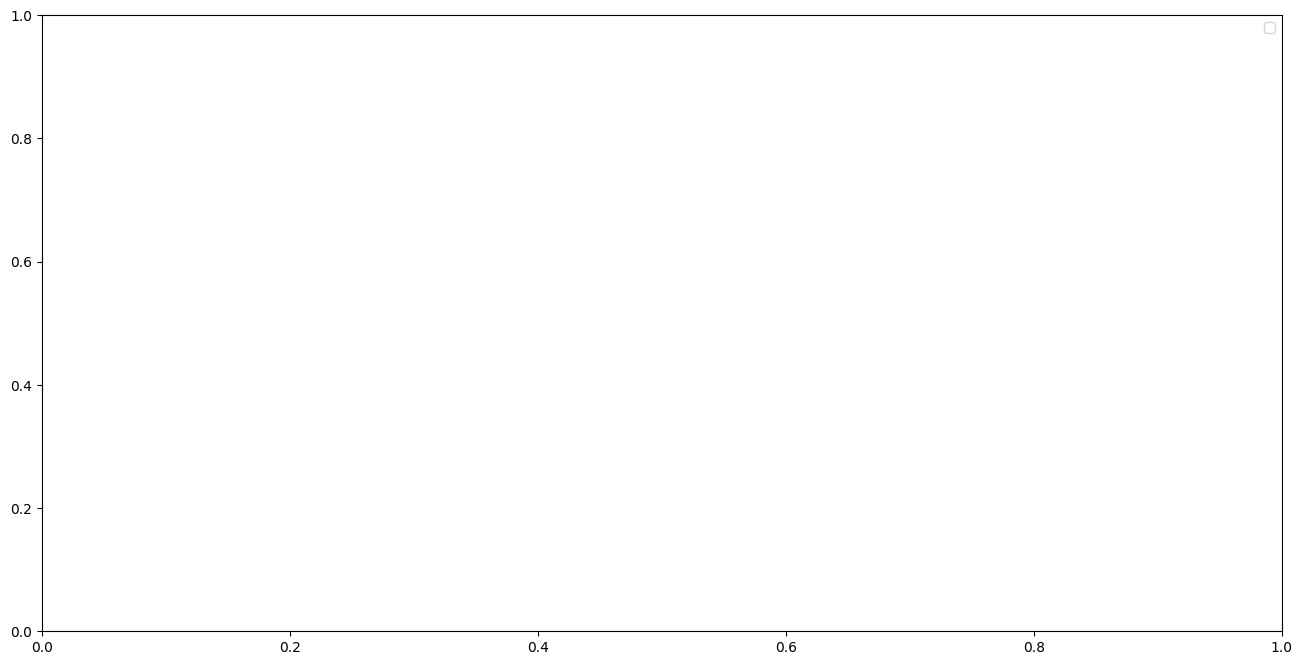

In [13]:
def plot(T, dt, N, freq):
    np.random.seed(0)
    vals = np.arange(0.0, T, dt)

    u = whitesignal(T, dt, freq=freq, batch_shape=(1,))
    u = torch.tensor(u, dtype=torch.float)
    u = u.to(device)

    plt.figure(figsize=(16, 8))
    offset = 0.0
    #plt.plot(vals, u.cpu()+offset, 'k', linewidth=1.0)

    # Linear Time Invariant (LTI) methods x' = Ax + Bu
    lti_methods = [
        'legs',
        'legt',
        'fourier',
    ]

    #for method in lti_methods:
    #    hippo = HiPPO(method=method, N=N, dt=dt, T=T).to(device)
    #    u_hippo = hippo.reconstruct(hippo(u))[-1].cpu()
    #    plt.plot(vals[-len(u_hippo):], u_hippo, label=method)

    # Original HiPPO-LegS, which uses time-varying SSM x' = 1/t [ Ax + Bu]
    # we call this "linear scale invariant"
    lsi_methods = ['legs']
    for method in lsi_methods:
        hippo = HiPPOScale(N=N, method=method, max_length=int(T/dt)).to(device)
        cs = hippo(u)
        u_hippo = hippo.reconstruct(hippo(u))[-1].cpu()
        u_hippo1 = hippo.reconstruct(hippo(u)).cpu()
        #plt.plot(vals[-len(u_hippo):], u_hippo, label=method+' (scaled)')

    # plt.xlabel('Time (normalized)', labelpad=-10)
    plt.legend()
    plt.savefig(f'function_approximation.pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    
    return u, u_hippo1 #u_hippo,cs#, u_hippo1

sig, recon_gu = plot(T=3, dt=1e-3, N=64, freq=3)

In [ ]:
reconsingle.shape

In [14]:
hippoour = HIPPO_LEGS(N=64, gbt_alpha=0.5, maxlength=3000)
_, B = hippoour.get_A_and_B(N=64)
GBTA, GBTB = hippoour.get_stacked_GBT()
our_c = hippoour.discrete_hippo_operator(A=GBTA, B=GBTB, f=sig, c_t=None)
our_recon = hippoour.reconstruct(our_c, B)


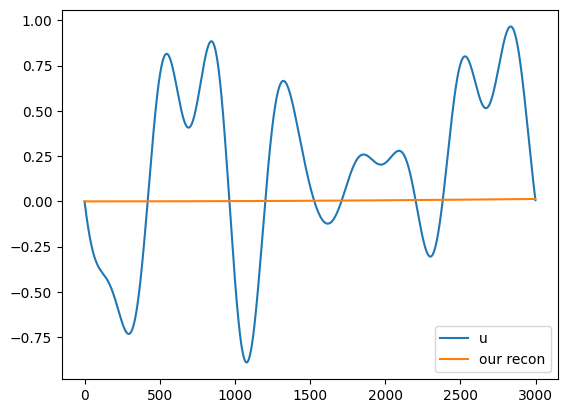

In [24]:

plt.plot(sig[0], label='u')
#plt.plot(torch.moveaxis(recon_gu, 1, 2)[0][-1], label='gu recon')
#plt.plot(np.moveaxis(our_recon, 1, 2)[0][-850], label='our recon')\
plt.plot(our_recon[0][-1], label='our recon')
#plt.plot(np.squeeze(np.moveaxis(our_recon, 1, 2)[0][-2], -1)*0.5)\
#plt.plot(torch.moveaxis(reconsingle, 0, 2)[-1].T)
plt.legend()
plt.show()

In [26]:
our_recon[0][-1].shape

(3000, 1)

In [20]:
print(our_recon.shape)
print(our_recon[0].shape)
print(our_recon[0].shape)

(1, 3000, 3000, 1)
(3000, 3000, 1)


In [ ]:
torch.moveaxis(reconsingle, 0, 1)[-1].T.shape